# `gym-multigrid` 简介

[`gym-multigrid`](https://github.com/Tran-Research-Group/gym-multigrid) 旨在提供轻量级、多智能体的网格环境。它最初基于这个[多网格环境](https://github.com/ArnaudFickinger/gym-multigrid)，但自那以后进行了大量修改和开发，超出了原始环境的范围。

In [1]:
import sys
from pathlib import Path
from IPython import display

root_dir = Path(".").resolve().parents[2]
root_dir = root_dir/"tests/DRLHP/gym-multigrid"
sys.path.extend([str(root_dir)])
temp_dir = Path("images")

## `gym-multigrid` Capture-the-Flag (CtF) 环境

In [2]:
import numpy as np
import imageio

from gym_multigrid.envs.ctf import Ctf1v1Env, CtFMvNEnv
from gym_multigrid.policy.ctf.heuristic import (
    FightPolicy,
    CapturePolicy,
    PatrolPolicy,
    RwPolicy,
    PatrolFightPolicy,
)
from gym_multigrid.utils.map import load_text_map
import matplotlib.pyplot as plt

简单测试：

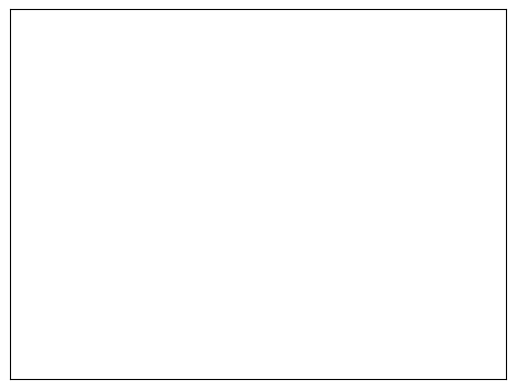

In [3]:
map_path: str = root_dir/"tests/assets/board.txt"

env = Ctf1v1Env(
    map_path=map_path, render_mode="human", observation_option="flattened"
)
obs, _ = env.reset()
env.render()

while True:
    action = np.random.choice(list(env.actions_set))
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        break

设置随机种子：

In [4]:
# TODO: might be good idea to include seeding test for other environments
def test_ctf_random_seeding(root_dir) -> None:
    map_path: str = f"{root_dir}/tests/assets/board.txt"
    env = Ctf1v1Env(
        map_path=map_path, render_mode="human", observation_option="flattened"
    )
    env.reset(seed=1)
    array1 = env.np_random.random(10)
    env.reset(seed=1)
    array2 = env.np_random.random(10)

    np.testing.assert_allclose(array1, array2)

test_ctf_random_seeding(root_dir)

MvN CtF：

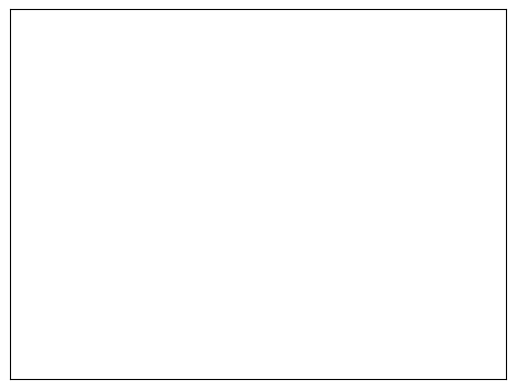

In [5]:
def test_ctf_mvn_human(root_dir) -> None:
    map_path: str = f"{root_dir}/tests/assets/board.txt"
    env = CtFMvNEnv(
        num_blue_agents=2,
        num_red_agents=2,
        map_path=map_path,
        render_mode="human",
        observation_option="flattened",
    )
    obs, _ = env.reset()
    env.render()

    while True:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        env.render()
        if terminated or truncated:
            break

    assert terminated or truncated

test_ctf_mvn_human(root_dir)

In [6]:
def test_ctf_mvn_rgb(root_dir, temp_dir=".temp") -> None:
    map_path: str = f"{root_dir}/tests/assets/board.txt"
    env = CtFMvNEnv(
        num_blue_agents=2,
        num_red_agents=2,
        map_path=map_path,
        render_mode="rgb_array",
        observation_option="flattened",
    )
    obs, _ = env.reset()
    frames = [env.render()]
    while True:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            break
    temp_dir = Path(temp_dir)
    (temp_dir/"animations").mkdir(exist_ok=True)
    imageio.mimsave(temp_dir/f"animations/ctf_mvn.gif", frames, duration=0.5)

    assert Path(temp_dir/f"animations/ctf_mvn.gif").exists()
test_ctf_mvn_rgb(root_dir, temp_dir)

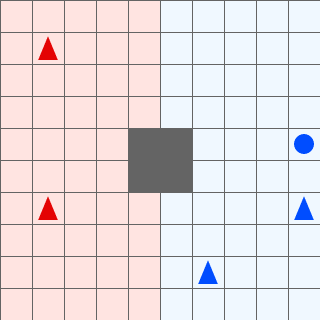

In [7]:
display.Image(temp_dir/f"animations/ctf_mvn.gif")

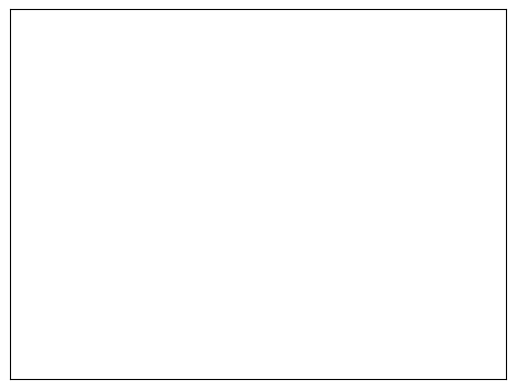

In [8]:
def test_fight_policy(root_dir, temp_dir=".temp") -> None:
    (temp_dir/"animations").mkdir(exist_ok=True)
    animation_path = temp_dir/"animations/ctf_mvn_fight_policy.gif"
    map_path = f"{root_dir}/tests/assets/board.txt"

    _field_map = load_text_map(map_path)
    enemy_policy = FightPolicy()

    env = CtFMvNEnv(
        num_blue_agents=2,
        num_red_agents=2,
        map_path=map_path,
        render_mode="human",
        observation_option="flattened",
        enemy_policies=[enemy_policy, RwPolicy()],
    )

    obs, _ = env.reset()
    frames = [env.render()]
    while True:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            break

    imageio.mimsave(animation_path, frames, duration=0.5)
    assert animation_path.exists()

test_fight_policy(root_dir, temp_dir)

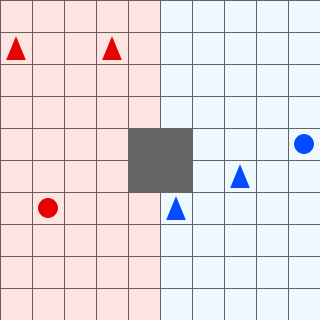

In [9]:
display.Image(temp_dir/"animations/ctf_mvn_fight_policy.gif")

![](.temp/)

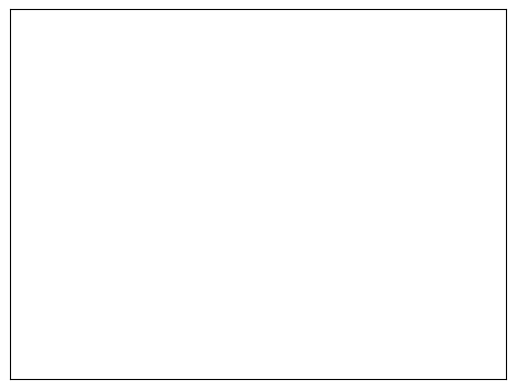

In [10]:
def test_capture_policy(map_path, animation_path) -> None:
    field_map = load_text_map(map_path)
    enemy_policy = CapturePolicy(field_map)

    env = CtFMvNEnv(
        num_blue_agents=2,
        num_red_agents=2,
        map_path=map_path,
        render_mode="human",
        observation_option="flattened",
        enemy_policies=[enemy_policy, RwPolicy()],
    )

    obs, _ = env.reset()
    frames = [env.render()]
    while True:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            break

    imageio.mimsave(animation_path, frames, duration=0.5)

    assert Path(animation_path).exists

animation_path: str = f"{temp_dir}/animations/ctf_mvn_capture_policy.gif"
map_path: str = f"{root_dir}/tests/assets/board.txt"
test_capture_policy(map_path, animation_path)

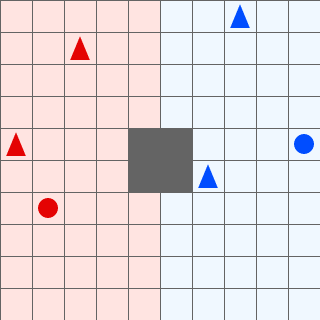

In [11]:
display.Image(f"{temp_dir}/animations/ctf_mvn_capture_policy.gif")

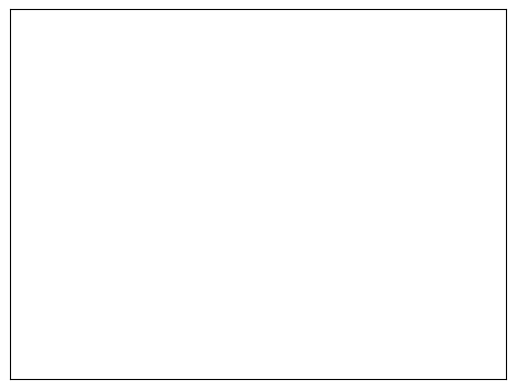

In [13]:
def test_patrol_policy(animation_path, map_path) -> None:
    field_map = load_text_map(map_path)
    enemy_policy = PatrolPolicy(field_map)

    env = CtFMvNEnv(
        num_blue_agents=2,
        num_red_agents=2,
        map_path=map_path,
        render_mode="human",
        observation_option="flattened",
        enemy_policies=enemy_policy,
    )

    obs, _ = env.reset()
    frames = [env.render()]
    while True:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            break

    imageio.mimsave(animation_path, frames, duration=0.5)

    assert Path(animation_path).exists

animation_path: str = f"{temp_dir}/animations/ctf_mvn_patrol_policy.gif"
map_path: str = f"{root_dir}/tests/assets/board.txt"
test_patrol_policy(animation_path, map_path)

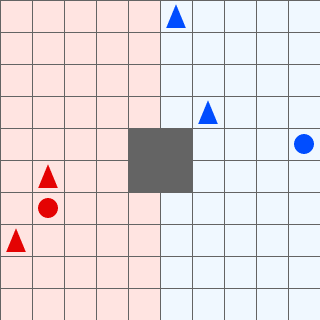

In [14]:
display.Image(f"{temp_dir}/animations/ctf_mvn_patrol_policy.gif")

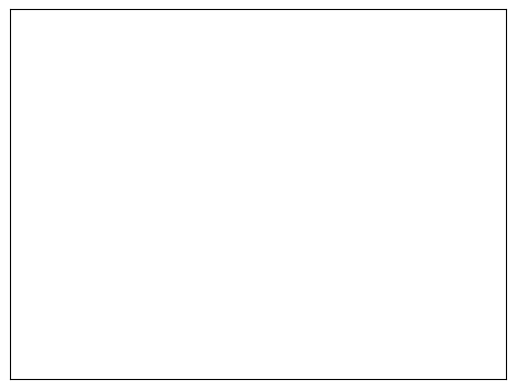

In [16]:
def test_patrol_fight_policy(map_path, animation_path) -> None:
    field_map = load_text_map(map_path)
    enemy_policy = PatrolFightPolicy(field_map)

    env = CtFMvNEnv(
        num_blue_agents=2,
        num_red_agents=2,
        map_path=map_path,
        render_mode="human",
        observation_option="flattened",
        enemy_policies=enemy_policy,
    )

    obs, _ = env.reset()
    frames = [env.render()]
    while True:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            break

    imageio.mimsave(animation_path, frames, duration=0.5)

    assert Path(animation_path).exists

animation_path: str = f"{temp_dir}/animations/ctf_mvn_patrol_fight_policy.gif"
map_path: str = f"{root_dir}/tests/assets/board.txt"
test_patrol_fight_policy(map_path, animation_path)

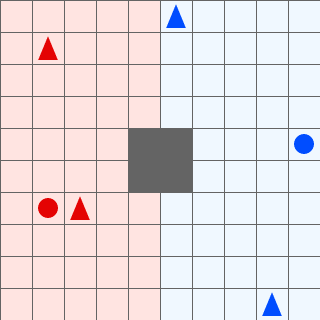

In [18]:
display.Image(f"{temp_dir}/animations/ctf_mvn_patrol_fight_policy.gif")

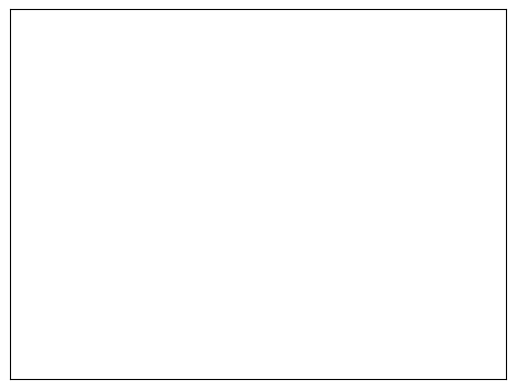

In [19]:
def test_mvn_ctf_render(map_path, img_save_path) -> None:
    env = CtFMvNEnv(
        num_blue_agents=2,
        num_red_agents=2,
        map_path=map_path,
        render_mode="human",
        observation_option="flattened",
    )
    obs, _ = env.reset()

    for _ in range(1):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

    img = env.render()
    plt.imsave(img_save_path, img, dpi=600)

    assert Path(img_save_path).exists

(temp_dir/"plots").mkdir()
img_save_path: str = f"{temp_dir}/plots/mvn_ctf_render.png"
map_path: str = f"{root_dir}/tests/assets/board.txt"
test_mvn_ctf_render(map_path, img_save_path)

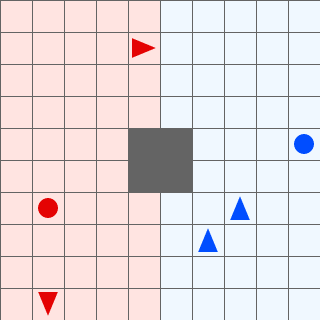

In [20]:
display.Image(f"{temp_dir}/plots/mvn_ctf_render.png")

## Collect 游戏

In [22]:
import gymnasium as gym
env_id = "gym_multigrid:multigrid-collect-v0"
env = gym.make(env_id)

obs, info = env.reset()
while True:
    actions = [env.action_space.sample() for a in env.agents]
    obs, reward, terminated, truncated, info = env.step(actions)
    if terminated or truncated:
        print(f"episode ended after {env.step_count} steps")
        print(f"agents collected {env.collected_balls} objects")
        break


TypeError: Expected num balls to be of type int,             however type <class 'numpy.int64'> was passed

![Collect Game Respawn](./images/collect-game-respawn.gif)

| Attribute             | Description    |
| --------------------- | -------------- |
| Action Space          | `Discrete(4)`  |
| Observation Space     | `np.array` of shape `grid.width x grid.height` |
| Observation Encoding  |`(OBJECT_IDX, COLOR_IDX, STATE)` |
| Reward                | `(0, 1)`       |
| Number of Agents      | `2`            |
| Termination Condition | `None`         |
| Truncation Steps      | `50`           |
| Creation              | `gymnasium.make("multigrid-collect-respawn-clustered-v0")` |

代理在网格中移动以收集物体。物体在被收集后会在随机位置重新生成。

## Maze 环境

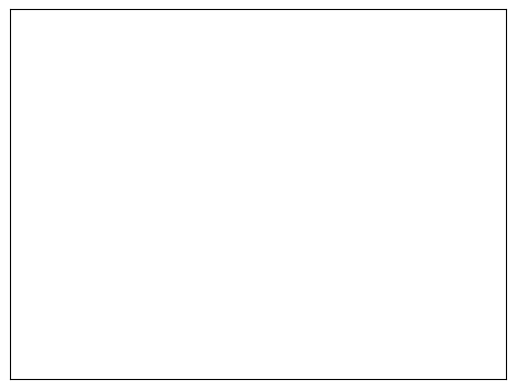

In [23]:
from gym_multigrid.envs.maze import MazeSingleAgentEnv


def test_maze(root_dir) -> None:
    map_path: str = f"{root_dir}/tests/assets/board_maze.txt"

    env = MazeSingleAgentEnv(
        map_path=map_path, render_mode="human", max_steps=200, step_penalty_ratio=0
    )
    obs, _ = env.reset()
    env.render()

    while True:
        action = np.random.choice(list(env.actions_set))
        obs, reward, terminated, truncated, info = env.step(action)
        env.render()
        if terminated or truncated:
            break

test_maze(root_dir)